In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.decomposition import PCA
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer, LabelBinarizer, Normalizer, OneHotEncoder
from sklearn.manifold import TSNE
from tqdm import tqdm

pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
def group_feature(df, key, target, aggs):   
    """
    输出不同聚合字段-方法组合dataframe
    df 数据表
    key 用于分组的字段  x, y, v, d
    target 用于计算聚合的字段
    aggs  聚合的方法  ['max','min','mean','std','skew','sum']
    """
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag  # 例如 x_max 代表输出每个船（id）数据中里面的最大值
#     print(agg_dict)
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
#     print(t)
    return t

def extract_feature(df, train):
    # x的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum', 'median'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # x的数量
    t = group_feature(df, 'ship','x',['count'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # y的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum', 'median'])
    train = pd.merge(train, t, on='ship', how='left')
    
#     # speed_time 的最大值，最小值，平均值，标准差，峰度，加和
#     t = group_feature(df, 'ship','speed_time',['max','min','mean','std','skew','sum', 'median'])
#     train = pd.merge(train, t, on='ship', how='left')
    
    # xy 的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','xy',['max','min','mean','std','skew','sum', 'median'])
    train = pd.merge(train, t, on='ship', how='left')
    
#     # xy_loc_pca 的最大值，最小值，平均值，标准差，峰度，加和
#     t = group_feature(df, 'ship','xy_loc_pca',['max','min','mean','std','skew','sum', 'median'])
#     train = pd.merge(train, t, on='ship', how='left')    
    
#     # vd的最大值，最小值，平均值，标准差，峰度，加和
#     t = group_feature(df, 'ship','vd',['max','min','mean','std','skew','sum'])
#     train = pd.merge(train, t, on='ship', how='left')
    
    # 速度的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','v',['max','min','mean','std','skew','sum', 'median'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # 方向的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum', 'median'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # x y 的最大值和最小值的交叉相减
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    
    train['x_median_a_y_median'] = train["x_median"] + train["y_median"]
    train['x_median_b_y_median'] = train["x_median"] - train["y_median"]
    train['x_median_c_y_median'] = train["x_median"] * train["y_median"]
    train['x_median_d_y_median'] = train["x_median"] / np.where(train['y_median']==0, 0.001, train['y_median'])
    
    bizhi = ["x", "y", "v", "d"]
    for i in range(4):
        for j in range(4):
            if i < j:
                n = "{}_d_{}".format(bizhi[i], bizhi[j])
                train[n] = train[bizhi[i]] / np.where(train[bizhi[j]]==0, 0.001, train[bizhi[j]])
    
    # slope 第一个值： y的最大值和最小值的差
    # slope 第二个值： x的最大值最小值的差，如果差值为0，则去极小值 0.001
    # slope代表x y 极差的比值，可以理解为斜度，坡度
    # np.where 是条件判断 True -> x;False -> y;
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min'])
    # x y 的极差相乘，表示该船的最大活动面积
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    # 每条船数据中出现小时值次数最多的值
    mode_hour = df.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
    train['mode_hour'] = train['ship'].map(mode_hour)
    
    # 小时的最大值，最小值
    t = group_feature(df, 'ship','hour',['max','min'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # 一次任务涉及到的小时数值
    hour_nunique = df.groupby('ship')['hour'].nunique().to_dict()
    # 一次任务涉及的天数
    date_nunique = df.groupby('ship')['date'].nunique().to_dict()
    train['hour_nunique'] = train['ship'].map(hour_nunique)
    train['date_nunique'] = train['ship'].map(date_nunique)
    
    # 一次任务的时间差
    t = df.groupby('ship')['time'].agg({'diff_time':lambda x:np.max(x)-np.min(x)}).reset_index()
    # 时间差的天数，秒数
    t['diff_day'] = t['diff_time'].dt.days
    t['diff_second'] = t['diff_time'].dt.seconds
    train = pd.merge(train, t, on='ship', how='left')
    return train

def extract_dt(df):
    # 时间格式转换
#     df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['time'] = pd.to_datetime(df['time'])

    # df['month'] = df['time'].dt.month
    # df['day'] = df['time'].dt.day
    df['date'] = df['time'].dt.date  # 提取日期
    df['hour'] = df['time'].dt.hour  # 提取小时
    # df = df.drop_duplicates(['ship','month'])
    df['weekday'] = df['time'].dt.weekday  # 提取星期
    return df

def PAC():
    pass

In [3]:
# 读取数据，整理列信息
# train = pd.read_hdf('../input/train.h5')
train = pd.read_csv("/Users/nick/Documents/dataset/智慧海洋/train_v2.csv")
train = train.drop(["Unnamed: 0"], axis=1)
train = train.rename(columns={
    "速度": "v",
    "方向": "d",
    "渔船ID": "ship",
})
# train = df.drop_duplicates(['ship','type'])
train = train.sort_values("ship")

In [4]:
# 读取数据，整理列信息
# test = pd.read_hdf('../input/test.h5')
test = pd.read_csv("/Users/nick/Documents/dataset/智慧海洋/test_v2.csv")

test = test.drop(["Unnamed: 0"], axis=1)
test = test.rename(columns={
    "速度": "v",
    "方向": "d",
    "渔船ID": "ship",
})
test = test.sort_values("ship")

In [5]:
# 合并训练集和测试集
train = train[:10000]
test = test[:5000]

train["record"] = "train"
test["record"] = "test"
df_all = pd.concat([train, test], axis=0)
df_all.head()

,d,record,ship,speed_time,time,type,v,x,y
399657,0,train,0,600.0,1900-11-09 16:18:22,拖网,0.0,6.118352e+06,5.130672e+06
399676,0,train,0,600.0,1900-11-09 13:08:23,拖网,0.0,6.118352e+06,5.130672e+06
399677,0,train,0,600.0,1900-11-09 12:58:23,拖网,0.0,6.118352e+06,5.130672e+06
399678,0,train,0,600.0,1900-11-09 12:48:23,拖网,0.0,6.118352e+06,5.130672e+06
399679,0,train,0,601.0,1900-11-09 12:38:22,拖网,0.0,6.118352e+06,5.130672e+06


In [6]:
# 查看数据的相关统计指标
df_all.describe()

,d,ship,speed_time,v,x,y
count,15000.000000,15000.000000,14962.000000,15000.000000,1.500000e+04,1.500000e+04
mean,119.754933,2343.803400,661.591632,1.743463,6.342667e+06,5.325664e+06
std,115.750804,3296.560713,313.853556,2.697080,3.762511e+05,2.991422e+05
min,0.000000,0.000000,1.000000,0.000000,5.228590e+06,4.577467e+06
25%,0.000000,10.000000,599.000000,0.110000,6.182402e+06,5.163718e+06
50%,91.000000,19.000000,600.000000,0.320000,6.262057e+06,5.242462e+06
75%,221.000000,7003.000000,603.000000,3.020000,6.510065e+06,5.503023e+06
max,360.000000,7012.000000,9118.000000,80.730000,7.119130e+06,6.136033e+06


# 对xy的高频坐标点进行one-hot变量的处理

In [7]:
# x y 值统计特征
df_all_xy_count = df_all[["ship", "x", "y"]]

print("df_all_xy_count", df_all_xy_count.shape)
# 删掉 ship-x-y 的重复值

df_all_xy_count["x"] = (df_all_xy_count["x"]/10).astype(int)
df_all_xy_count["y"] = (df_all_xy_count["y"]/10).astype(int)

df_all_xy_count = df_all_xy_count.drop_duplicates(["ship", "x", "y"])
print("df_all_xy_count", df_all_xy_count.shape)

# df_all_xy_count["ship"] = df_all_xy_count.astype("object")
# df_all_xy_count["x"] = df_all_xy_count.astype("object")
# df_all_xy_count["y"] = df_all_xy_count.astype("object")

x_counts = df_all_xy_count.groupby("x")["x"].count()
x_count_dict = x_counts[x_counts >= 1].to_dict()

y_counts = df_all_xy_count.groupby("y")["y"].count()
y_count_dict = y_counts[y_counts >= 1].to_dict()

# x_count_dict
# y_count_dict

print("x_count_dict: {}".format(len(x_count_dict)))
print("y_count_dict: {}".format(len(y_count_dict)))

# 查看xy的交叉值
# print(set(x_count_dict) & set(y_count_dict))

df_all_xy_count (15000, 3)
df_all_xy_count (6623, 3)
x_count_dict: 5822
y_count_dict: 5833


In [8]:
# 船号
df_all.groupby("ship")["ship"].count()

ship
0       414
1       385
2       233
3       335
4       401
5       375
6       394
7       348
8       366
9       397
10      397
11      377
12      416
13      426
14      402
15      382
16      398
17      265
18      409
19      388
20      376
21      415
22      422
23      399
24      392
25      388
26      100
7000    373
7001    458
7002    410
7003    425
7004    398
7005    404
7006    316
7007    411
7008    430
7009    419
7010    412
7011    398
7012    146
Name: ship, dtype: int64

In [9]:
ship_index_list = list(df_all.groupby("ship")["ship"].count().index)
print(ship_index_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012]


In [10]:
# 整理每一条船的 x => [] 和 y => [] 还有对应的船号
x_count_list = []
y_count_list = []
ship_list = []
for i in tqdm(ship_index_list):
    ship_list.append(i)
    x_count_list.append(list(df_all_xy_count[df_all_xy_count["ship"]==i]["x"]))
    y_count_list.append(list(df_all_xy_count[df_all_xy_count["ship"]==i]["y"]))

100%|██████████| 40/40 [00:00<00:00, 740.84it/s]


In [11]:
# ship 对应 x‘ y’ 的 df
xy_count_list = pd.DataFrame({"ship": ship_list, "x_count_list": x_count_list, "y_count_list": y_count_list})

# 补充one hot编码的列， 全部填充0
for a, _ in tqdm(x_count_dict.items()):
    a = "{}_x".format(a)
    xy_count_list[a] = 0
    
for a, _ in tqdm(y_count_dict.items()):
    a = "{}_y".format(a)
    xy_count_list[a] = 0
    
xy_count_list.head(1)

100%|██████████| 5833/5833 [00:07<00:00, 823.34it/s]


,ship,x_count_list,y_count_list,522859_x,522871_x,522917_x,522947_x,522973_x,522975_x,522984_x,522999_x,523028_x,523151_x,523194_x,523334_x,523380_x,523528_x,523567_x,523757_x,523799_x,524007_x,524030_x,524270_x,524273_x,524489_x,524526_x,524665_x,524758_x,524841_x,524991_x,525011_x,525054_x,525157_x,525234_x,525250_x,525343_x,525446_x,525478_x,525540_x,525633_x,525710_x,525727_x,525831_x,525924_x,525951_x,526018_x,526111_x,526185_x,526205_x,526309_x,...,612523_y,612524_y,612547_y,612594_y,612605_y,612627_y,612659_y,612672_y,612678_y,612682_y,612694_y,612716_y,612727_y,612728_y,612741_y,612753_y,612755_y,612756_y,612761_y,612764_y,612771_y,612774_y,612775_y,612786_y,612828_y,612832_y,612834_y,612843_y,612844_y,612845_y,612850_y,612987_y,613064_y,613171_y,613297_y,613345_y,613452_y,613461_y,613504_y,613510_y,613522_y,613528_y,613556_y,613558_y,613576_y,613577_y,613591_y,613592_y,613601_y,613603_y
0,0,"[611835, 615203, 615122, 615042, 614961, 61488...","[513067, 512487, 512521, 512556, 512590, 51262...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# 填充每个船只的one hot编码 对应的值
print(xy_count_list.shape)
# xy_count_list = xy_count_list.reset_index(drop=True)

for index2, i_list in tqdm(enumerate(xy_count_list["x_count_list"])):
    
    common_key = set(list(x_count_dict.keys())) & set(i_list)
    common_key = list(common_key)
    
    common_key_s = []
    for c in common_key:
        common_key_s.append("{}_x".format(c))
    
    try:
        xy_count_list.loc[index2, common_key_s] = 1
    except Exception as e:
        raise e

for index2, i_list in tqdm(enumerate(xy_count_list["y_count_list"])):
    
    common_key = set(list(y_count_dict.keys())) & set(i_list)
    common_key = list(common_key)
    
    common_key_s = []
    for c in common_key:
        common_key_s.append("{}_y".format(c))
    
    try:
        xy_count_list.loc[index2, common_key_s] = 1
    except Exception as e:
        raise e

5it [00:00, 39.05it/s]

(40, 11658)


40it [00:01, 24.51it/s]
40it [00:01, 24.91it/s]


In [13]:
xy_count_list.head(3)

,ship,x_count_list,y_count_list,522859_x,522871_x,522917_x,522947_x,522973_x,522975_x,522984_x,522999_x,523028_x,523151_x,523194_x,523334_x,523380_x,523528_x,523567_x,523757_x,523799_x,524007_x,524030_x,524270_x,524273_x,524489_x,524526_x,524665_x,524758_x,524841_x,524991_x,525011_x,525054_x,525157_x,525234_x,525250_x,525343_x,525446_x,525478_x,525540_x,525633_x,525710_x,525727_x,525831_x,525924_x,525951_x,526018_x,526111_x,526185_x,526205_x,526309_x,...,612523_y,612524_y,612547_y,612594_y,612605_y,612627_y,612659_y,612672_y,612678_y,612682_y,612694_y,612716_y,612727_y,612728_y,612741_y,612753_y,612755_y,612756_y,612761_y,612764_y,612771_y,612774_y,612775_y,612786_y,612828_y,612832_y,612834_y,612843_y,612844_y,612845_y,612850_y,612987_y,613064_y,613171_y,613297_y,613345_y,613452_y,613461_y,613504_y,613510_y,613522_y,613528_y,613556_y,613558_y,613576_y,613577_y,613591_y,613592_y,613601_y,613603_y
0,0,"[611835, 615203, 615122, 615042, 614961, 61488...","[513067, 512487, 512521, 512556, 512590, 51262...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"[610244, 605404, 605322, 605569, 605661, 60575...","[511275, 504619, 504589, 504657, 504676, 50469...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,"[618308, 618319, 618308, 618248]","[519368, 519368, 519357, 519369]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# 删除不用的列
xy_count_list_drop_df_ship = xy_count_list[["ship"]]
xy_count_list_drop_df = xy_count_list.drop(["ship", "x_count_list", "y_count_list"], axis=1)
xy_count_list_drop_df.head(1)

,522859_x,522871_x,522917_x,522947_x,522973_x,522975_x,522984_x,522999_x,523028_x,523151_x,523194_x,523334_x,523380_x,523528_x,523567_x,523757_x,523799_x,524007_x,524030_x,524270_x,524273_x,524489_x,524526_x,524665_x,524758_x,524841_x,524991_x,525011_x,525054_x,525157_x,525234_x,525250_x,525343_x,525446_x,525478_x,525540_x,525633_x,525710_x,525727_x,525831_x,525924_x,525951_x,526018_x,526111_x,526185_x,526205_x,526309_x,526338_x,526403_x,526462_x,...,612523_y,612524_y,612547_y,612594_y,612605_y,612627_y,612659_y,612672_y,612678_y,612682_y,612694_y,612716_y,612727_y,612728_y,612741_y,612753_y,612755_y,612756_y,612761_y,612764_y,612771_y,612774_y,612775_y,612786_y,612828_y,612832_y,612834_y,612843_y,612844_y,612845_y,612850_y,612987_y,613064_y,613171_y,613297_y,613345_y,613452_y,613461_y,613504_y,613510_y,613522_y,613528_y,613556_y,613558_y,613576_y,613577_y,613591_y,613592_y,613601_y,613603_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# 对较高频的坐标进行降维
print(xy_count_list_drop_df.shape)
pca = PCA(n_components=3)
reduced_xy_count = pca.fit_transform(xy_count_list_drop_df)
print(reduced_xy_count.shape)

reduced_xy_count_df = pd.DataFrame(reduced_xy_count)
reduced_xy_count_df["ship"] = xy_count_list_drop_df_ship["ship"].values
reduced_xy_count_df.head(2)

(40, 11655)
(40, 3)


,0,1,2,ship
0,-0.389924,-0.073972,-0.235604,0
1,0.224246,0.169789,-0.194754,1


# 对坐标划分网格

In [16]:
# 确定xy网格范围
xmin = df_all["x"].min()
xmax = df_all["x"].max()

ymin = df_all["y"].min()
ymax = df_all["y"].max()

x_offset = xmax - xmin
y_offset = ymax - ymin

offset_count = 30

x_box = x_offset / offset_count
y_box = y_offset / offset_count


print("x min: {}".format(xmin))
print("x max: {}".format(xmax))
print("x offset: {}".format(x_offset))
print("x box: {}".format(x_box))

print("y min: {}".format(ymin))
print("y max: {}".format(ymax))
print("y offset: {}".format(y_offset))
print("y box: {}".format(y_box))

# 计算网格区域
x_list = []
for i in range(offset_count + 1):
    x_list.append(xmin + i * x_box)
    
y_list = []
for i in range(offset_count + 1):
    y_list.append(ymin + i * y_box)
    
pd.DataFrame({"x_area": x_list, "y_area": y_list})[:2]

x min: 5228590.203706587
x max: 7119129.668697878
x offset: 1890539.464991291
x box: 63017.982166376365
y min: 4577467.435465305
y max: 6136032.746930093
y offset: 1558565.3114647875
y box: 51952.17704882625


,x_area,y_area
0,5.228590e+06,4.577467e+06
1,5.291608e+06,4.629420e+06


In [17]:
# 对网格编码后赋值
def map_loc_x(x):
    for i in range(offset_count+1):
        if x <= x_list[i]:
            return i
        if x > x_list[i] and x <= x_list[i+1]:
            return i

def map_loc_y(y):
    for i in range(offset_count+1):
        if y <= y_list[i]:
            return i
        if y > y_list[i] and y <= y_list[i+1]:
            return i
        
df_all["x_loc"] = df_all["x"].apply(map_loc_x)
df_all["y_loc"] = df_all["y"].apply(map_loc_y)

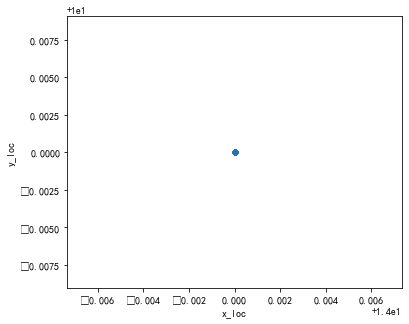

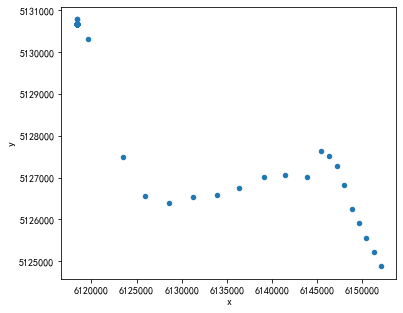

In [18]:
df_all[df_all["ship"]==0][["x_loc", "y_loc"]].plot.scatter(x='x_loc', y='y_loc', figsize=(6,5))
plt.show()
df_all[df_all["ship"]==0][["x", "y"]].plot.scatter(x='x', y='y', figsize=(6,5))
plt.show()

In [19]:
# 构造新列代表每一个区域
df_all["x_y_loc_area"] = df_all['x_loc'].astype(str) + ',' + df_all['y_loc'].astype(str)
df_all.head(1)

,d,record,ship,speed_time,time,type,v,x,y,x_loc,y_loc,x_y_loc_area
399657,0,train,0,600.0,1900-11-09 16:18:22,拖网,0.0,6.118352e+06,5.130672e+06,14,10,"14,10"


In [20]:
# 抽取每一个区域和对应ship
df_xyloc = df_all[["x_y_loc_area"]]

df_xyloc_dummies = pd.get_dummies(df_xyloc)
print(df_xyloc_dummies.shape)
df_xyloc_dummies.head(2)

(15000, 64)


,"x_y_loc_area_0,0","x_y_loc_area_1,0","x_y_loc_area_12,8","x_y_loc_area_13,10","x_y_loc_area_13,8","x_y_loc_area_13,9","x_y_loc_area_14,10","x_y_loc_area_14,11","x_y_loc_area_14,12","x_y_loc_area_14,9","x_y_loc_area_15,10","x_y_loc_area_15,11","x_y_loc_area_15,12","x_y_loc_area_16,11","x_y_loc_area_16,12","x_y_loc_area_16,13","x_y_loc_area_17,10","x_y_loc_area_17,11","x_y_loc_area_17,12","x_y_loc_area_17,13","x_y_loc_area_17,15","x_y_loc_area_17,16","x_y_loc_area_18,13","x_y_loc_area_18,14","x_y_loc_area_18,15","x_y_loc_area_18,17","x_y_loc_area_19,14","x_y_loc_area_19,15","x_y_loc_area_19,16","x_y_loc_area_19,17","x_y_loc_area_19,18","x_y_loc_area_20,15","x_y_loc_area_20,18","x_y_loc_area_20,19","x_y_loc_area_20,21","x_y_loc_area_21,15","x_y_loc_area_21,16","x_y_loc_area_21,17","x_y_loc_area_21,21","x_y_loc_area_21,23","x_y_loc_area_22,16","x_y_loc_area_22,17","x_y_loc_area_22,23","x_y_loc_area_23,17","x_y_loc_area_23,18","x_y_loc_area_23,23","x_y_loc_area_24,18","x_y_loc_area_24,19","x_y_loc_area_24,20","x_y_loc_area_24,23","x_y_loc_area_25,19","x_y_loc_area_25,20","x_y_loc_area_25,23","x_y_loc_area_26,18","x_y_loc_area_26,19","x_y_loc_area_26,23","x_y_loc_area_27,23","x_y_loc_area_28,22","x_y_loc_area_28,29","x_y_loc_area_29,22","x_y_loc_area_29,23","x_y_loc_area_29,25","x_y_loc_area_29,26","x_y_loc_area_29,29"
399657,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399676,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
print(df_xyloc_dummies.shape)
pca = PCA(n_components=3)
reduced_xy_loc = pca.fit_transform(df_xyloc_dummies)
print(reduced_xy_loc.shape)

print(reduced_xy_loc)

df_all["xy_loc_pca_1"] = reduced_xy_loc[:, 0]
df_all["xy_loc_pca_2"] = reduced_xy_loc[:, 1]
df_all["xy_loc_pca_3"] = reduced_xy_loc[:, 2]
df_all.head(2)

(15000, 64)
(15000, 3)
[[-0.17954143 -0.05320815 -0.00405727]
 [-0.17954143 -0.05320815 -0.00405727]
 [-0.17954143 -0.05320815 -0.00405727]
 ...
 [-0.24380637 -0.29450694 -0.70078054]
 [-0.24380637 -0.29450694 -0.70078054]
 [-0.24380637 -0.29450694 -0.70078054]]


,d,record,ship,speed_time,time,type,v,x,y,x_loc,y_loc,x_y_loc_area,xy_loc_pca_1,xy_loc_pca_2,xy_loc_pca_3
399657,0,train,0,600.0,1900-11-09 16:18:22,拖网,0.0,6.118352e+06,5.130672e+06,14,10,"14,10",-0.179541,-0.053208,-0.004057
399676,0,train,0,600.0,1900-11-09 13:08:23,拖网,0.0,6.118352e+06,5.130672e+06,14,10,"14,10",-0.179541,-0.053208,-0.004057


# xyd 降维

In [22]:
df_all_xy = df_all[["x", "y", "d"]]
print(df_all_xy.shape)
pca = PCA(n_components=1)
reduced_xy = pca.fit_transform(df_all_xy)
print(reduced_xy.shape)
df_all["xy"] = reduced_xy

(15000, 3)
(15000, 1)


In [23]:
# df_all_vd = df_all[["v", "d"]]
# print(df_all_vd.shape)
# pca = PCA(n_components=1)     #加载PCA算法，设置降维后主成分数目为2
# reduced_vd = pca.fit_transform(df_all_vd)#对样本进行降维
# print(reduced_vd.shape)
# df_all["vd"] = reduced_vd

# 处理时间数据

In [24]:
# 处理时间数据
df_all = extract_dt(df_all)
df_all.head(1)

,d,record,ship,speed_time,time,type,v,x,y,x_loc,y_loc,x_y_loc_area,xy_loc_pca_1,xy_loc_pca_2,xy_loc_pca_3,xy,date,hour,weekday
399657,0,train,0,600.0,1900-11-09 16:18:22,拖网,0.0,6.118352e+06,5.130672e+06,14,10,"14,10",-0.179541,-0.053208,-0.004057,296851.886401,1900-11-09,16,4


In [25]:
# 删除重复行数据
print("df_all", df_all.shape)
df_label = df_all.drop_duplicates('ship')
print("df_label", df_label.shape)

df_all (15000, 19)
df_label (40, 19)


In [26]:
# 查看分类占比
df_label['type'].value_counts(1)

拖网    0.666667
围网    0.296296
刺网    0.037037
Name: type, dtype: float64

In [27]:
# 标签使用数字代替
type_map = dict(zip(df_label['type'].unique(), np.arange(3)))
type_map_rev = {v:k for k,v in type_map.items()}
df_label['type'] = df_label['type'].map(type_map)
type_map_rev

{0: '拖网', 1: '围网', 2: '刺网'}

In [28]:
# 分类占比
df_label['type'].value_counts(1)

0.0    0.666667
1.0    0.296296
2.0    0.037037
Name: type, dtype: float64

In [29]:
# 构造新列
df_label = extract_feature(df_all, df_label)

In [30]:
# 降维后合并
reduced_xy_count_df = reduced_xy_count_df.rename(columns={
    0: "xy_count_pca_1",
    1: "xy_count_pca_2",
    2: "xy_count_pca_3",
})
df_label = pd.merge(df_label, reduced_xy_count_df, on='ship', how='left')
df_label.head(3)

,d,record,ship,speed_time,time,type,v,x,y,x_loc,y_loc,x_y_loc_area,xy_loc_pca_1,xy_loc_pca_2,xy_loc_pca_3,xy,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_median,x_count,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_median,xy_max,xy_min,xy_mean,xy_std,xy_skew,xy_sum,xy_median,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_median,d_max,d_min,d_mean,d_std,d_skew,d_sum,d_median,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,x_median_a_y_median,x_median_b_y_median,x_median_c_y_median,x_median_d_y_median,x_d_y,x_d_v,x_d_d,y_d_v,y_d_d,v_d_d,slope,area,mode_hour,hour_max,hour_min,hour_nunique,date_nunique,diff_time,diff_day,diff_second,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3
0,0,train,0,600.0,1900-11-09 16:18:22,0.0,0.00,6.118352e+06,5.130672e+06,14,10,"14,10",-0.179541,-0.053208,-0.004057,296851.886401,1900-11-09,16,4,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,6.118352e+06,414,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,296851.886401,273943.749096,296176.008102,3472.660569,-5.359642,1.226169e+08,296851.886401,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.00,129,0,4.613527,21.247770,4.483093,1910,0.0,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.124902e+07,987679.431865,3.139126e+13,1.192505,1.192505,6.118352e+09,6.118352e+09,5.130672e+09,5.130672e+09,0.0,0.175380,1.990200e+08,15,23,0,24,4,2 days 23:48:51,2,85731,-0.389924,-0.073972,-0.235604
1,0,train,1,600.0,1900-11-08 11:10:30,0.0,0.05,6.102450e+06,5.112760e+06,13,10,"13,10",-0.243806,-0.294507,-0.700781,320422.257010,1900-11-08,11,3,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,6.102450e+06,385,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,5.112760e+06,405264.887807,320422.252954,340621.802760,29397.353718,0.895650,1.311394e+08,320422.257010,10.47,0.0,1.607922,2.412688,1.590284,619.05,0.05,336,0,56.153247,91.449382,1.418867,21619,0.0,52978.013345,70016.655842,-936597.872550,1.059593e+06,1.121521e+07,989690.230130,3.120036e+13,1.193573,1.193573,1.220490e+08,6.102450e+09,1.022552e+08,5.112760e+09,50.0,1.321617,3.709343e+09,19,23,0,24,4,2 days 23:39:47,2,85187,0.224246,0.169789,-0.194754
2,40,train,2,593.0,1900-11-17 03:41:35,0.0,0.00,6.183090e+06,5.193685e+06,15,11,"15,11",-0.244810,-0.310635,0.713085,207017.647586,1900-11-17,3,5,6.183191e+06,6.182482e+06,6.183011e+06,207.869601,-2.155218,1.440641e+09,6.183090e+06,233,5.193696e+06,5.193576e+06,5.193682e+06,21.740609,-4.563165,1.210128e+09,5.193685e+06,207488.446415,206939.169717,207081.588471,160.623004,2.126376,4.825001e+07,207017.647586,50.46,0.0,0.595150,3.415824,13.631590,138.67,0.22,360,0,123.356223,123.097127,0.657506,28742,71.0,708.835147,120.565000,-988786.086021,9.896155e+05,1.137677e+07,989404.963687,3.211302e+13,1.190502,1.190502,6.183090e+09,1.545772e+05,5.193685e+09,1.298421e+05,0.0,0.170089,8.546071e+04,17,23,0,24,4,2 days 23:34:57,2,84897,-0.371490,-0.070273,-0.223711


In [31]:
# 拆出暂不需要的特征
delete_list = ['speed_time', "record", 'ship','type','time','diff_time','date', 'x_y_loc_area']
features = [x for x in df_label.columns if x not in delete_list]
target = 'type'

# features = []

In [32]:
# 查看训练用到的列
print(len(features), "\n", '    '.join(features))

74 
 d    v    x    y    x_loc    y_loc    xy_loc_pca_1    xy_loc_pca_2    xy_loc_pca_3    xy    hour    weekday    x_max    x_min    x_mean    x_std    x_skew    x_sum    x_median    x_count    y_max    y_min    y_mean    y_std    y_skew    y_sum    y_median    xy_max    xy_min    xy_mean    xy_std    xy_skew    xy_sum    xy_median    v_max    v_min    v_mean    v_std    v_skew    v_sum    v_median    d_max    d_min    d_mean    d_std    d_skew    d_sum    d_median    x_max_x_min    y_max_y_min    y_max_x_min    x_max_y_min    x_median_a_y_median    x_median_b_y_median    x_median_c_y_median    x_median_d_y_median    x_d_y    x_d_v    x_d_d    y_d_v    y_d_d    v_d_d    slope    area    mode_hour    hour_max    hour_min    hour_nunique    date_nunique    diff_day    diff_second    xy_count_pca_1    xy_count_pca_2    xy_count_pca_3


In [33]:
train_label = df_label[df_label["record"] == "train"]
test_label = df_label[df_label["record"] == "test"]

train_label = train_label.drop(["record"], axis=1)
test_label = test_label.drop(["record", "type"], axis=1)

train_label[features].head(3)

,d,v,x,y,x_loc,y_loc,xy_loc_pca_1,xy_loc_pca_2,xy_loc_pca_3,xy,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_median,x_count,y_max,y_min,y_mean,y_std,y_skew,y_sum,y_median,xy_max,xy_min,xy_mean,xy_std,xy_skew,xy_sum,xy_median,v_max,v_min,v_mean,v_std,v_skew,v_sum,v_median,d_max,d_min,d_mean,d_std,d_skew,d_sum,d_median,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,x_median_a_y_median,x_median_b_y_median,x_median_c_y_median,x_median_d_y_median,x_d_y,x_d_v,x_d_d,y_d_v,y_d_d,v_d_d,slope,area,mode_hour,hour_max,hour_min,hour_nunique,date_nunique,diff_day,diff_second,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3
0,0,0.00,6.118352e+06,5.130672e+06,14,10,-0.179541,-0.053208,-0.004057,296851.886401,16,4,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,6.118352e+06,414,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,5.130672e+06,296851.886401,273943.749096,296176.008102,3472.660569,-5.359642,1.226169e+08,296851.886401,9.39,0.0,0.265966,1.321248,5.520205,110.11,0.00,129,0,4.613527,21.247770,4.483093,1910,0.0,33686.667453,5907.975523,-987570.399385,1.027165e+06,1.124902e+07,987679.431865,3.139126e+13,1.192505,1.192505,6.118352e+09,6.118352e+09,5.130672e+09,5.130672e+09,0.0,0.175380,1.990200e+08,15,23,0,24,4,2,85731,-0.389924,-0.073972,-0.235604
1,0,0.05,6.102450e+06,5.112760e+06,13,10,-0.243806,-0.294507,-0.700781,320422.257010,11,3,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,6.102450e+06,385,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,5.112760e+06,405264.887807,320422.252954,340621.802760,29397.353718,0.895650,1.311394e+08,320422.257010,10.47,0.0,1.607922,2.412688,1.590284,619.05,0.05,336,0,56.153247,91.449382,1.418867,21619,0.0,52978.013345,70016.655842,-936597.872550,1.059593e+06,1.121521e+07,989690.230130,3.120036e+13,1.193573,1.193573,1.220490e+08,6.102450e+09,1.022552e+08,5.112760e+09,50.0,1.321617,3.709343e+09,19,23,0,24,4,2,85187,0.224246,0.169789,-0.194754
2,40,0.00,6.183090e+06,5.193685e+06,15,11,-0.244810,-0.310635,0.713085,207017.647586,3,5,6.183191e+06,6.182482e+06,6.183011e+06,207.869601,-2.155218,1.440641e+09,6.183090e+06,233,5.193696e+06,5.193576e+06,5.193682e+06,21.740609,-4.563165,1.210128e+09,5.193685e+06,207488.446415,206939.169717,207081.588471,160.623004,2.126376,4.825001e+07,207017.647586,50.46,0.0,0.595150,3.415824,13.631590,138.67,0.22,360,0,123.356223,123.097127,0.657506,28742,71.0,708.835147,120.565000,-988786.086021,9.896155e+05,1.137677e+07,989404.963687,3.211302e+13,1.190502,1.190502,6.183090e+09,1.545772e+05,5.193685e+09,1.298421e+05,0.0,0.170089,8.546071e+04,17,23,0,24,4,2,84897,-0.371490,-0.070273,-0.223711


In [44]:
# lgbm的参数
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
    'learning_rate': 0.01,
}

# 交叉验证 五折
fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 特征和标签
X = train_label[features].copy()
y = train_label[target]

# 模型列表
models = []
# 预测值
pred = np.zeros((len(test_label),3))  # onehot形式 (2000, 3)
oof = np.zeros((len(X), 3))  # onehot形式 (7000, 3)

# 循环交叉验证
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):

    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])  # 筛选训练数据
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])        # 筛选验证数据

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)  # 训练模型
    models.append(model)  # 模型列表
    
    # 预测标签，每个结果是 (len ,3)
    val_pred = model.predict(X.iloc[val_idx])  
    oof[val_idx] = val_pred
    
    # 原始标签
    val_y = y.iloc[val_idx]
    
    # 输出最大值
    val_pred = np.argmax(val_pred, axis=1)
    
    # 计算f1值
    print(index, 'val f1(指定次数的随机验证集F1值: )', metrics.f1_score(val_y, val_pred, average='macro'))
    
    # 预测待提交测试集结果
    test_pred = model.predict(test_label[features])
    print("test_pred", test_pred)
    pred += test_pred
    print("pred", pred)


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.891685	valid_1's multi_logloss: 0.226264
Early stopping, best iteration is:
[1]	training's multi_logloss: 0.891685	valid_1's multi_logloss: 0.226264
0 val f1(指定次数的随机验证集F1值: ) 1.0
test_pred [[0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]
 [0.64 0.32 0.04]]
pred [[0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]
 [0.128 0.064 0.008]]
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.891686	valid_1's multi_logloss: 0.729527
Early stopping, best iteration is:
[1]	training's multi_loglos

 [0.66666667 0.29166667 0.04166667]]
pred [[1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]
 [1.0617971  0.48053623 0.05766667]]
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.88312	valid_1's multi_logloss: 1.04688
Early stopping, best iteration is:
[1]	training's multi_logloss: 0.88312	valid_1's multi_logloss: 1.04688
8 val f1(指定次数的随机验证集F1值: ) 0.3333333333333333
test_pred [[0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 0.04]
 [0.68 0.28 

In [35]:
# 综合五次的交叉验证的结果评估值
oof = np.argmax(oof, axis=1)
print('【准确率】oof f1: ', metrics.f1_score(oof, y, average='macro'))

# origin 0.8666565020816382
# speed time 0.8556040441133175
# speed time + xy 0.869776300826063
# xy 0.8695008449788421
# speed time + xyvd 0.8666262659963254
# speed time + xyd 0.8712710026618916
# speed time + xyv 0.8677183665397498
# speed time + xy + vd 0.8657659692232876
# speed time + xyd + vd 0.8683521658107259
# xy loc 0.8755378306270695

【准确率】oof f1:  0.26666666666666666


In [36]:
pred = np.argmax(pred, axis=1)
sub = test_label[['ship']]
sub['pred'] = pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
sub.to_csv('result.csv', index=None, header=None)

0    1.0
Name: pred, dtype: float64


In [37]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)

In [38]:
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)

In [39]:
df

,name,score
0,area,0
55,xy_mean,0
53,xy_loc_pca_3,0
52,xy_loc_pca_2,0
51,xy_loc_pca_1,0
50,xy_count_pca_3,0
49,xy_count_pca_2,0
48,xy_count_pca_1,0
47,xy,0
46,x_sum,0


In [40]:
df.shape

(74, 2)

In [41]:
# from __future__ import print_function
# import pandas as pd
# import lightgbm as lgb
# import sklearn
# import numpy
# import hyperopt
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# import colorama
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score


# N_HYPEROPT_PROBES = 500
# HYPEROPT_ALGO = tpe.suggest  #  tpe.suggest OR hyperopt.rand.suggest

# # ----------------------------------------------------------

# colorama.init()

# # ---------------------------------------------------------------------

# def get_lgb_params(space):
#     lgb_params = dict()
#     lgb_params['boosting_type'] = space['boosting_type'] if 'boosting_type' in space else 'gbdt'
#     lgb_params['objective'] = 'multiclass'
# #     lgb_params['metric'] = 'rmse'
#     lgb_params['learning_rate'] = space['learning_rate']
#     lgb_params['num_leaves'] = int(space['num_leaves'])
#     lgb_params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
#     lgb_params['min_sum_hessian_in_leaf'] = space['min_sum_hessian_in_leaf']
#     lgb_params['max_depth'] = -1
#     lgb_params['lambda_l1'] = space['lambda_l1'] if 'lambda_l1' in space else 0.0
#     lgb_params['lambda_l2'] = space['lambda_l2'] if 'lambda_l2' in space else 0.0
#     lgb_params['max_bin'] = int(space['max_bin']) if 'max_bin' in space else 256
#     lgb_params['feature_fraction'] = space['feature_fraction']
#     lgb_params['bagging_fraction'] = space['bagging_fraction']
#     lgb_params['bagging_freq'] = int(space['bagging_freq']) if 'bagging_freq' in space else 1
#     lgb_params['nthread'] = 4,
#     lgb_params['num_class'] = 3
#     return lgb_params

# # ---------------------------------------------------------------------

# obj_call_count = 0
# cur_best_score = 0 # 0 or np.inf
# log_writer = open( 'log/lgb-hyperopt-log.txt', 'w' )


# def objective(space):
#     global obj_call_count, cur_best_score

#     obj_call_count += 1

#     print('\nLightGBM objective call #{} cur_best_score={:7.5f}'.format(obj_call_count,cur_best_score) )

#     lgb_params = get_lgb_params(space)

#     sorted_params = sorted(space.items(), key=lambda z: z[0])
#     params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
#     print('Params: {}'.format(params_str) )
    
#     kf = KFold(n_splits=3, shuffle=True, random_state=0)
#     out_of_fold = np.zeros(len(X))
#     for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
#         D_train = lgb.Dataset(X.iloc[train_idx], label=y[train_idx])
#         D_val = lgb.Dataset(X.iloc[val_idx], label=y[val_idx])
#         # Train
#         num_round = 10000
#         clf = lgb.train(lgb_params,
#                            D_train,
#                            num_boost_round=num_round,
#                            # metrics='mlogloss',
#                            valid_sets=D_val,
#                            # valid_names='val',
#                            # fobj=None,
#                            # feval=None,
#                            # init_model=None,
#                            # feature_name='auto',
#                            # categorical_feature='auto',
#                            early_stopping_rounds=200,
#                            # evals_result=None,
#                            verbose_eval=False,
#                            # learning_rates=None,
#                            # keep_training_booster=False,
#                            # callbacks=None
#                            )
#         # predict
#         nb_trees = clf.best_iteration
#         val_loss = clf.best_score['valid_0']
#         print('nb_trees={} val_loss={}'.format(nb_trees, val_loss))
#         out_of_fold[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=nb_trees)
#         score = metrics.f1_score(out_of_fold, y)

#     print('val_r2_score={}'.format(score))

#     log_writer.write('score={} Params:{} nb_trees={}\n'.format(score, params_str, nb_trees ))
#     log_writer.flush()

#     if score>cur_best_score:
#         cur_best_score = score
#         print(colorama.Fore.GREEN + 'NEW BEST SCORE={}'.format(cur_best_score) + colorama.Fore.RESET)
#     return {'loss': -score, 'status': STATUS_OK}

# # --------------------------------------------------------------------------------

# space ={
#         'num_leaves': hp.quniform ('num_leaves', 10, 100, 1),
#         'min_data_in_leaf':  hp.quniform ('min_data_in_leaf', 10, 100, 1),
#         'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
#         'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
#         'learning_rate': hp.uniform('learning_rate', 0, 0.01),
# #         'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
#         'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', 0, 2.3),
#         'max_bin': hp.quniform ('max_bin', 88, 200, 1),
#         'bagging_freq': hp.quniform ('bagging_freq', 1, 15, 1),
#         'lambda_l1': hp.uniform('lambda_l1', 0, 10 ),
#         'lambda_l2': hp.uniform('lambda_l2', 0, 10 ),
#        }

# trials = Trials()
# best = hyperopt.fmin(fn=objective,
#                      space=space,
#                      algo=HYPEROPT_ALGO,
#                      max_evals=N_HYPEROPT_PROBES,
#                      trials=trials,
#                      verbose=1)

# print('-'*50)
# print('The best params:')
# print( best )
# print('\n\n')

                                                       
LightGBM objective call #1 cur_best_score=0.00000
Params: bagging_fraction=0.9975253492306869 bagging_freq=10.0 feature_fraction=0.810386244043721 lambda_l1=6.597939406566765 lambda_l2=7.919307539716293 learning_rate=0.007497813740744136 max_bin=129.0 min_data_in_leaf=42.0 min_sum_hessian_in_leaf=1.6854463518259843 num_leaves=81.0
nb_trees=1 val_loss={'multi_logloss': 4.344057058939837}
  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

job exception: shape mismatch: value array of shape (9,3) could not be broadcast to indexing result of shape (9,)


  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]


ValueError: shape mismatch: value array of shape (9,3) could not be broadcast to indexing result of shape (9,)